## 1 - Import Required Packages



In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

## 2 - Outline of the Functions Implemented

These functions are the building blocks of a convolutional neural network!

- Convolution functions:
    - Zero Padding
    - Convolve window 
    - Convolution forward
    - Convolution backward
- Pooling functions:
    - Pooling forward
    - Create mask 
    - Distribute value
    - Pooling backward
    
In this notebook, all the functions are implemented from scratch in `numpy`. 

**Note**: For every forward function, there is a corresponding backward equivalent. Hence, at every step of forward module some parameters are stored in a cache. These parameters are used to compute gradients during backpropagation. 

## 3 - Implementation 

Although programming frameworks make convolutions easy to use, they remain one of the hardest concepts to understand in Deep Learning. A convolution layer transforms an input volume into an output volume of different size, as shown below. 


Implementation of  two helper functions: one for zero padding and the other for computing the convolution function itself. 

### 3.1 - Zero-Padding

Zero-padding adds zeros around the border of an image:

In [2]:
import numpy as np

def zero_pad(X, pad):
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), mode='constant')
    
    return X_pad


### Testing the function

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 9, 9, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


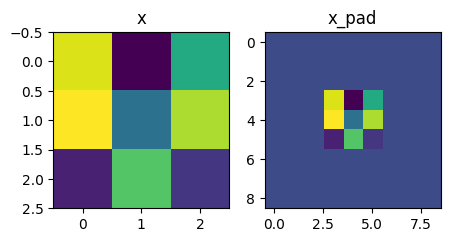

In [3]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 3)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1, 1])
print ("x_pad[1,1] =\n", x_pad[1, 1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0, :, :, 0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0, :, :, 0])


### 3.2 - Single Step of Convolution 

In this part, a single step of convolution is implemented, in which the filter is applied to a single position of the input. This will be used to build a convolutional unit, which: 

- Takes an input volume 
- Applies a filter at every position of the input
- Outputs another volume (usually of different size)



In [4]:
def conv_single_step(a_slice_prev, W, b):
    s = a_slice_prev * W
    
    Z = np.sum(s)
    
    Z = Z + float(b)
    
    return Z


### Testing the function

In [5]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)


Z = -6.999089450680221


/tmp/ipykernel_18/354161064.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z = Z + float(b)


### 3.3 - Convolutional Neural Networks - Forward Pass

In the forward pass, you will take many filters and convolve them on the input. Each 'convolution' gives you a 2D matrix output. You will then stack these outputs to get a 3D volume: 


In [6]:
import numpy as np

def zero_pad(X, pad):
    return np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), mode='constant')

def conv_single_step(a_slice_prev, W, b):
    s = a_slice_prev * W
    Z = np.sum(s)
    Z = Z + float(b)
    return Z

def conv_forward(A_prev, W, b, hparameters):
    
    # Retrieve dimensions from A_prev's shape (≈1 line)  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape (≈1 line)
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters" (≈2 lines)
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume using the formula given above. 
    # Hint: use int() to apply the 'floor' operation. (≈2 lines)
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1
    
    # Initialize the output volume Z with zeros. (≈1 line)
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                       # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]           # Select ith training example's padded activation
        for h in range(n_H):                 # loop over vertical axis of the output volume
            # Find the vertical start and end of the current "slice" (≈2 lines)
            vert_start = h * stride
            vert_end = vert_start + f
            
            for w in range(n_W):             # loop over horizontal axis of the output volume
                # Find the horizontal start and end of the current "slice" (≈2 lines)
                horiz_start = w * stride
                horiz_end = horiz_start + f
                
                for c in range(n_C):         # loop over channels (= #filters) of the output volume
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈3 lines)
                    weights = W[:, :, :, c]
                    biases = b[:, :, :, c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache


### Testing the function

In [7]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 7, 4)
W = np.random.randn(3, 3, 4, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
z_mean = np.mean(Z)
z_0_2_1 = Z[0, 2, 1]
cache_0_1_2_3 = cache_conv[0][1][2][3]
print("Z's mean =\n", z_mean)
print("Z[0,2,1] =\n", z_0_2_1)
print("cache_conv[0][1][2][3] =\n", cache_0_1_2_3)


Z's mean =
 0.5511276474566768
Z[0,2,1] =
 [-2.17796037  8.07171329 -0.5772704   3.36286738  4.48113645 -2.89198428
 10.99288867  3.03171932]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


/tmp/ipykernel_18/2958004705.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z = Z + float(b)


## 4 - Pooling Layer 

The pooling (POOL) layer reduces the height and width of the input. It helps reduce computation, as well as helps make feature detectors more invariant to its position in the input. There are two types of pooling layers: 

- Max-pooling layer: slides an ($f, f$) window over the input and stores the max value of the window in the output.

- Average-pooling layer: slides an ($f, f$) window over the input and stores the average value of the window in the output.


These pooling layers have no parameters for backpropagation to train. However, they have hyperparameters such as the window size $f$. This specifies the height and width of the $f \times f$ window you would compute a *max* or *average* over. 



In [8]:
import numpy as np

def pool_forward(A_prev, hparameters, mode = "max"):
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    A = np.zeros((m, n_H, n_W, n_C))              
    
    for i in range(m):                         
        for h in range(n_H):                     
            vert_start = h * stride
            vert_end = vert_start + f
            
            for w in range(n_W):                
                horiz_start = w * stride
                horiz_end = horiz_start + f
                
                for c in range(n_C):           
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    cache = (A_prev, hparameters)
    
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache


### Testing Function

In [9]:
# Case 1: stride of 1
print("CASE 1:\n")
np.random.seed(1)
A_prev_case_1 = np.random.randn(2, 5, 5, 3)
hparameters_case_1 = {"stride" : 1, "f": 3}

print("mode = max")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])


# Case 2: stride of 2
print("\n\033[0mCASE 2:\n")
np.random.seed(1)
A_prev_case_2 = np.random.randn(2, 5, 5, 3)
hparameters_case_2 = {"stride" : 2, "f": 3}

print("mode = max")
print("A.shape = " + str(A.shape))
print("A[0] =\n", A[0])
print()

A, cache = pool_forward(A_prev_case_2, hparameters_case_2, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1] =\n", A[1])



CASE 1:

mode = max


NameError: name 'A' is not defined

## The forward passes of all the layers of a convolutional network are implemented :))


## 5 - Backpropagation in Convolutional Neural Networks (OPTIONAL / UNGRADED)



In [ ]:
import numpy as np

def conv_backward(dZ, cache):
  
    
    # Retrieve information from "cache"
    (A_prev, W, b, hparameters) = cache
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                          
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))
    
    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                       # loop over the training examples
        
        # select ith training example from A_prev_pad and dA_prev_pad
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_H):                   # loop over vertical axis of the output volume
            for w in range(n_W):               # loop over horizontal axis of the output volume
                for c in range(n_C):           # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice"
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f

                    # Use the corners to define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    # Update gradients for the window and the filter's parameters using the code formulas given above
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:, :, :, c] * dZ[i, h, w, c]
                    dW[:, :, :, c] += a_slice * dZ[i, h, w, c]
                    db[:, :, :, c] += dZ[i, h, w, c]
                    
        # Set the ith training example's dA_prev to the unpadded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
        if pad != 0:
            dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
        else:
            dA_prev[i, :, :, :] = da_prev_pad
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db


### Testing functions

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 2,
               "stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

# Test conv_backward
dA, dW, db = conv_backward(Z, cache_conv)

print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))



## 5.2 Pooling Layer - Backward Pass


In [ ]:
def create_mask_from_window(x):
  
    mask = (x == np.max(x))
    
    return mask


### Testing Functions

In [ ]:
np.random.seed(1)
x = np.random.randn(2, 3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x = np.array([[-1, 2, 3],
              [2, -3, 2],
              [1, 5, -2]])

y = np.array([[False, False, False],
     [False, False, False],
     [False, True, False]])
mask = create_mask_from_window(x)



### 5.2.2 - Average Pooling - Backward Pass 



In [ ]:
def distribute_value(dz, shape):
    
    # Retrieve dimensions from shape (≈1 line)
    (n_H, n_W) = shape
    
    # Compute the value to distribute on the matrix (≈1 line)
    average = dz / (n_H * n_W)
    
    # Create a matrix where every entry is the "average" value (≈1 line)
    a = np.ones(shape) * average
    
    return a


### Testing functions

In [ ]:
a = distribute_value(2, (2, 2))
print('distributed value =', a)


### 5.2.3 Putting it Together: Pooling Backward 

Everything needed to compute backward propagation on a pooling layer is implemented.


In [ ]:
def pool_backward(dA, cache, mode="max"):
    
    # Retrieve information from cache
    (A_prev, hparameters) = cache
    
    # Retrieve hyperparameters from "hparameters"
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    # Retrieve dimensions from A_prev's shape and dA's shape
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    # Initialize dA_prev with zeros
    dA_prev = np.zeros_like(A_prev)
    
    for i in range(m):                     # loop over the training examples
        
        # select training example from A_prev
        a_prev = A_prev[i]
        
        for h in range(n_H):               # loop on the vertical axis
            for w in range(n_W):           # loop on the horizontal axis
                for c in range(n_C):       # loop over the channels (depth)
                    
                    # Find the corners of the current "slice"
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    
                    # Compute the backward propagation in both modes
                    if mode == "max":
                        
                        # Use the corners and "c" to define the current slice from a_prev
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        
                        # Create the mask from a_prev_slice
                        mask = create_mask_from_window(a_prev_slice)
                        
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += mask * dA[i, h, w, c]
                        
                    elif mode == "average":
                        
                        # Get the value da from dA
                        da = dA[i, h, w, c]
                        
                        # Define the shape of the filter as fxf
                        shape = (f, f)
                        
                        # Distribute it to get the correct slice of dA_prev.
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev


### Testing functions

In [ ]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
print(A.shape)
print(cache[0].shape)
dA = np.random.randn(5, 4, 2, 2)

dA_prev1 = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev1[1,1] = ', dA_prev1[1, 1])  
print()

dA_prev2 = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev2[1,1] = ', dA_prev2[1, 1]) 